## Inverse Cooking: Recipe Generation from Food Images

In [71]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
# from src.args import get_parser
import pickle
# from src.model import get_model
from torchvision import transforms
from src.utils.output_utils import prepare_output
from PIL import Image
import time
import json

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [72]:
from src.args import get_parser
from src.model import get_model
data_dir = '../data'

In [73]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [74]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [75]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [76]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/Users/luisrita/PycharmProjects/HyperFoods/venv/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 2.188387870788574


In [77]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [78]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = 1

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [79]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = True # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)
    
# -----------------------------------------------
  
f = open('../data/id_url.json')
id_url = (json.load(f))# [0:100]
f.close()

urls = []
ids = []

keys = list(id_url.keys())

for i in range(0, len(id_url)):
    
    for j in range(0, len(id_url[keys[i]])):
        
        urls.append(id_url[keys[i]][j])
        
        if id_url[keys[i]][j]:
            
            ids.append(keys[i])

print(id_url)
print(urls)
print(ids)

# -----------------------------------------------

demo_urls = urls

demo_files = demo_urls if use_urls else demo_imgs

#demo_files = demo_imgs

{'000018c8a5': [], '000033e39b': [], '000035f7ed': [], '00003a70b1': ['http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/47/91/49/picaYYmb9.jpg', 'http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/47/91/49/picpy37SW.jpg', 'http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/47/91/49/picX9CNE2.jpg'], '00004320bb': [], '0000631d90': [], '000075604a': ['https://img-global.cpcdn.com/001_recipes/5806945844854784/0x0/photo.jpg'], '00007bfd16': ['http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/40/86/94/picNQPjbC.jpg', 'http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/40/86/94/picjXIJN8.jpg'], '000095fc1d': ['http://tastykitchen.com/recipes/wp-content/uploads/sites/2/2011/06/IMG_2692-630x420-410x615.jpg'], '0000973574': [], '0000a4bcf6': [], '0000b1e2b5': ['http://assets.epicurious

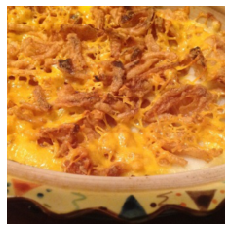

['cheese', 'onion', 'pepper', 'potato', 'milk', 'salt', 'butter', 'cream']
{}
['potato', 'cheese', 'butter', 'pepper', 'onion', 'cream', 'milk', 'salt']
{'00003a70b1': ['cheese', 'onion', 'pepper', 'potato', 'milk', 'salt', 'butter', 'cream']}
['cheese', 'pepper', 'onion', 'egg', 'potato', 'salt', 'milk', 'cream', 'butter']
{'00003a70b1': ['potato', 'cheese', 'butter', 'pepper', 'onion', 'cream', 'milk', 'salt']}
['chicken', 'pepper', 'salt', 'lemon', 'oil', 'paprika', 'juice']
{'00003a70b1': ['cheese', 'pepper', 'onion', 'egg', 'potato', 'salt', 'milk', 'cream', 'butter']}
['sugar', 'egg', 'flour', 'rhubarb', 'salt', 'butter', 'cinnamon', 'strawberries', 'water']
{'00003a70b1': ['cheese', 'pepper', 'onion', 'egg', 'potato', 'salt', 'milk', 'cream', 'butter'], '000075604a': ['chicken', 'pepper', 'salt', 'lemon', 'oil', 'paprika', 'juice']}
['sugar', 'flour', 'butter', 'salt', 'rhubarb', 'cinnamon', 'baking_powder', 'egg', 'milk', 'extract']
{'00003a70b1': ['cheese', 'pepper', 'onion', 

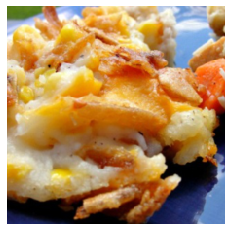

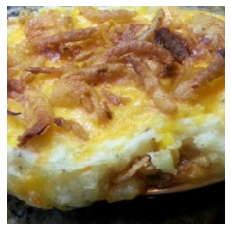

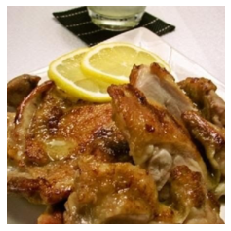

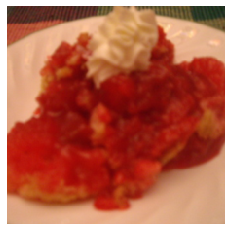

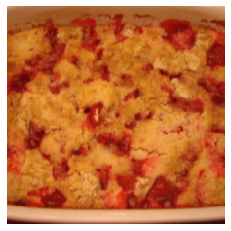

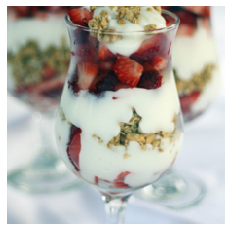

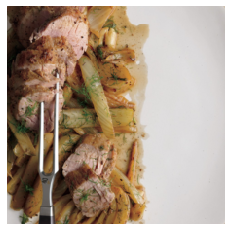

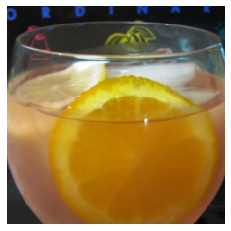

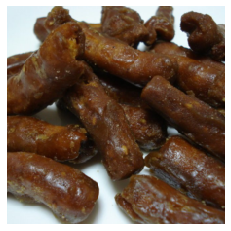

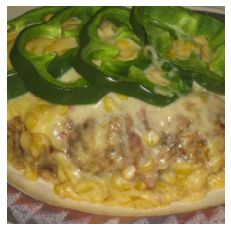

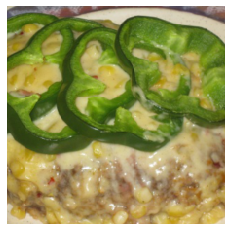

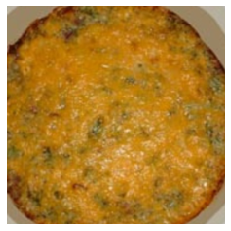

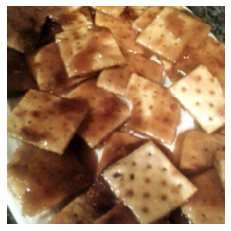

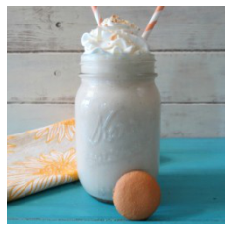

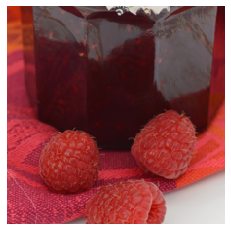

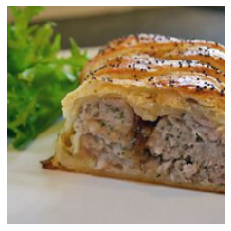

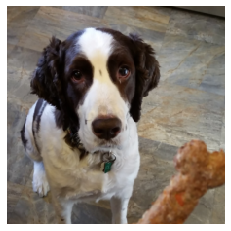

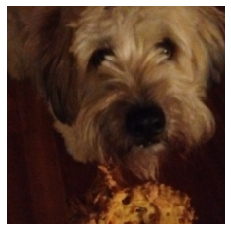

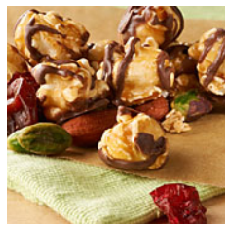

OSError: cannot identify image file <_io.BytesIO object at 0x118158b48>

In [80]:
ii = -1
final_output = {}

for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    
    ii += 1
        
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        print(outs['ingrs'])
        print(final_output)
        
        final_output[ids[ii]] = outs['ingrs']
        
'''
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
        
'''

